This notebook illustrates how to use *FastHR* to estimate the hardness ratio (HR) and its cumulative distribution function (CDF) for an X-ray source (or any source with Poisson nature). HR is defined as $(\lambda_H-\lambda_S)/(\lambda_H+\lambda_S)$, where $\lambda_S$ and $\lambda_H$ are the soft-band (SB) and hard-band (HB) count rates, respectively. *FastHR* implements a Bayesian approach. Each count rate needs two parameters (denoted as $\psi_\bullet$) specifying its prior; For example, $(\psi_{S1}, \psi_{S2})$ are the prior parameters for $\lambda_S$. The SB and HB are assumed to be independent. More details are explained in Appendix A of Zou et al. (2023).

Let's work through an example.

In [1]:
# load relevant pacakges
from fasthr.main import *
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import timeit

# Preparation step

In the very first step, we need to generate an external table (I will call it `lnI`), which is independent of your data.

You need to specify the following parameters:<br>
`nmax`: the upper bound of SB counts.<br>
`mmax`: the upper bound of HB counts.<br>
`psi1_S`: $\psi_{S1}$, the first parameter of the $\lambda_S$ prior.<br>
`psi1_H`: $\psi_{H1}$, the first parameter of the $\lambda_H$ prior.<br>
`ygrid`: the `y` grid. `y` is a parameter transformed from HR and ranges between 0 and 1.

**Notes:**
* You don't need to know what `y` and `lnI` exactly are to master *FastHR*. Only two things should be kept in mind for `y`. First, the `ygrid` size equals the size of the HR grid on which you want to evaluate the HR CDF; second, `ygrid` should contain 0 and 1. A straightforward way of generating `ygrid` is using `np.linspace(0., 1., ...)`.
* You must ensure that your input observed SB and HB counts within the source region later on do not exceed `nmax` and `mmax`, respectively. As long as this requirement is satisfied, increasing `nmax` and `mmax` won't change your results.
* Since `lnI` is independent of your data, you only need to generate it once, no matter how many sources you have. Also, you can save it onto your disk so that you won't need to re-generate it later.
* `lnI` could consume lots of memory if your `nmax`, `mmax`, and/or `ygrid` size are too large. Try making these numbers smaller if you face memory problems. I don't think this is a real problem in most cases because, after all, you don't need to use *FastHR* if your source has 10,000 counts.

In [2]:
# set the parameters.
nmax = 200
mmax = 200
psi1_S = 1.
psi1_H = 1.
ygrid = np.linspace(0., 1., 200)

# generate the external table lnI using the tabul_lnI function.
# the parameters of tabul_lnI is (nmax, mmax, ygrid, psi1_S, psi1_H).
# this may take some time.
# It's totally okay if you get the following warning:
#    "RuntimeWarning: divide by zero encountered in log
#    return np.log(special.betainc(mm + psi1_H, nn + psi1_S, yy))"
time_start = timeit.default_timer()
lnI = tabul_lnI(nmax, mmax, ygrid, psi1_S, psi1_H)
print("Tabulating lnI, time: %.2fs" % (timeit.default_timer() - time_start))

Tabulating lnI, time: 1.68s


/Users/zoufan/opt/anaconda3/lib/python3.8/site-packages/fasthr/main.py:22: RuntimeWarning: divide by zero encountered in log
  return np.log(special.betainc(mm + psi1_H, nn + psi1_S, yy))


If you already have `ygrid` and `lnI` saved before, you can load them using the `generate_lnI` function, which also enables you to reset the grid size of `ygrid` and the corresponding `lnI`.

In [3]:
# you could save the original ygrid and lnI.
ygrid_file_name = "ygrid_Smax{}_Hmax{}_psi1S{}_psi1H{}.npy".format(nmax, mmax, psi1_S, psi1_H)
lnI_file_name = "lnI_Smax{}_Hmax{}_psi1S{}_psi1H{}.npy".format(nmax, mmax, psi1_S, psi1_H)
np.save(ygrid_file_name, ygrid)
np.save(lnI_file_name, lnI)

# the parameters of generate_lnI are
# 1. the desired new grid size of y, which must be at least 2 and does not exceed the original ygrid size.
# 2. the .npy file path of ygrid.
# 3. the .npy file path of lnI
# below, I create new ygrid and lnI, where the new ygrid sizes 100 instead of 200.
ygrid, lnI = generate_lnI(100, ygrid_file_name, lnI_file_name)

# Input data and do the calculation

We even haven't specified other prior parameters, $\psi_{S2}$ and $\psi_{H2}$. Let's do it right now.

In [4]:
psi2_S = 0.
psi2_H = 0.

Now I am going to ask you a question: do you accurately know the mean background intensity? *Yes* and *No* are both common answers. Depending upon your answer, we need to adopt slightly different approaches.

### The *Yes* Case: you assume that the mean background intensity is accurately known.

In [5]:
# set up the data
# (I just made up some data)
S = 20 # total soft-band counts in the source region
H = 15 # total hard-band counts in the source region
e_S = 1. # soft-band exposure time
e_H = 1. # hard-band exposure time
xi_S = 10 # the expected soft-band background count rate in the source region
xi_H = 10 # the expected hard-band background count rate in the source region

# first, input the data and prior parameters.
# the input parameters are (S, H, e_S, e_H, psi1_S, psi2_S, psi1_H, psi2_H, xi_S = xi_S, xi_H = xi_H).
myhr = fasthr(S, H, e_S, e_H, psi1_S, psi2_S, psi1_H, psi2_H, xi_S = xi_S, xi_H = xi_H)

# second, initialize it by calling the init_hrcdf method.
# we need specify your answer on the background in this step.
# since your answer is "yes", input "fixed", as shown below.
myhr.init_hrcdf("fixed")

# third, do the calculation using calc_hrcdf.
# it requires two parameters - ygrid and lnI, which are generated in the Preparation step at the beginning.
# you should ensure that the psi1_S and psi1_H that are used to generate ygrid and lnI are the same
#     as the input psi1_S and psi1_H to myhr.
# the function returns (hrgrid, cdfgrid).
#     hrgrid: the HR grid between -1 and 1.
#     cdfgrid: the posterior CDF evaluated on the HR grid.
hrgrid, cdfgrid = myhr.calc_hrcdf(ygrid, lnI)

You can extract further information from `hrgrid` and `cdfgrid`, as exampled below.

<IPython.core.display.Math object>

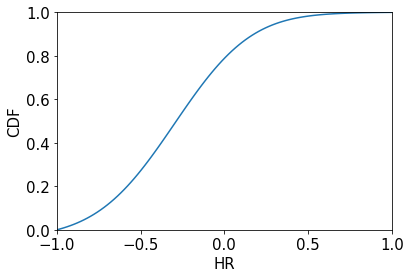

In [6]:
# print the median HR and certainty.
lower_err, median, upper_err = np.interp([0.16, 0.5, 0.84], cdfgrid, hrgrid)
display.display(display.Math("\mathrm{{HR}}={0:.2f}_{{-{1:.2f}}}^{{+{2:.2f}}}"\
    .format(median, median - lower_err, upper_err - median)))

# plot the HR CDF.
plt.plot(hrgrid, cdfgrid)
plt.xlabel("HR", fontsize = 15.)
plt.ylabel("CDF", fontsize = 15.)
plt.xticks(np.linspace(-1., 1., 5), fontsize = 15.)
plt.yticks(fontsize = 15.)
plt.xlim(-1., 1.)
plt.ylim(0., 1.)
plt.show()

### The *No* Case: the mean background intensity is not accurately known.

In this case, you need to estimate the background intensity together with the source intensity, and thus the input background data is slightly different from the *Yes* Case.

In [7]:
# set up the data
# (I just made up some data)
S = 20 # total soft-band counts in the source region
H = 15 # total hard-band counts in the source region
e_S = 1. # soft-band exposure time
e_H = 1. # hard-band exposure time
B_S = 50 # soft-band counts in the background region.
B_H = 50 # hard-band counts in the background region.
psi3_S, psi4_S = 1., 0. # parameters of the background soft-band count-rate priors.
psi3_H, psi4_H = 1., 0. # parameters of the background hard-band count-rate priors.
r_S = 5. # the soft-band ratio between the background-region area and the source-region area.
r_H = 5. # the hard-band ratio between the background-region area and the source-region area.

# input the data and prior parameters.
myhr = fasthr(S, H, e_S, e_H, psi1_S, psi2_S, psi1_H, psi2_H,
              B_S = B_S, B_H = B_H,
              psi3_S = psi3_S, psi4_S = psi4_S,
              psi3_H = psi3_H, psi4_H = psi4_H,
              r_S = r_S, r_H = r_H)

# initialization. Note that you should input "unfixed" for the "No" Case here.
myhr.init_hrcdf("unfixed")

# do the calculation.
hrgrid, cdfgrid = myhr.calc_hrcdf(ygrid, lnI)

# print the median HR and certainty.
lower_err, median, upper_err = np.interp([0.16, 0.5, 0.84], cdfgrid, hrgrid)
display.display(display.Math("\mathrm{{HR}}={0:.2f}_{{-{1:.2f}}}^{{+{2:.2f}}}"\
    .format(median, median - lower_err, upper_err - median)))

<IPython.core.display.Math object>